In [1]:
#换用GASA（测试）

import os
import numpy as np
import random
import molvecgen

import rdkit
from rdkit import Chem, DataStructs, rdBase
from rdkit.Chem import rdFMCS, AllChem, RDKFingerprint, Descriptors, rdMolDescriptors, AllChem, QED
from rdkit import DataStructs
from rdkit.Chem.Draw import IPythonConsole

default_path = os.getcwd()
if default_path[-4:] != "GASA":
    os.chdir(os.path.join(default_path, "GASA"))
import gasa
os.chdir(default_path)

import h5py
import pandas as pd
import ast
import pickle
from ipywidgets import interact

from ddc_pub import ddc_v3 as ddc

# 计算子结构相似度
def get_sim(mol, sub_mol) -> float: 
    try:
        res = rdFMCS.FindMCS([mol, sub_mol], timeout=1, bondCompare=rdFMCS.BondCompare.CompareAny, ringMatchesRingOnly=True, atomCompare=rdFMCS.AtomCompare.CompareAny)
        if res.smartsString == "" or res.canceled:
            return 0
        mcs_mol = Chem.MolFromSmarts(res.smartsString)
        Chem.SanitizeMol(mcs_mol)

        mcs_mol_fp = RDKFingerprint(mcs_mol)
        sub_mol_fp = RDKFingerprint(sub_mol)
        sim = DataStructs.FingerprintSimilarity(sub_mol_fp, mcs_mol_fp)

        return sim
    except Exception as e:
        #print(e)
        return 0

# 计算合成可及性
def get_gasas(mols: list=[]) -> list:
    if default_path[-4:] != "GASA":
        os.chdir(os.path.join(default_path, "GASA"))
    smiles_list = [Chem.MolToSmiles(mol) for mol in mols]
    gasas = gasa.GASA(smiles_list)[1]
    os.chdir(default_path)
    return gasas

# 计算除了gasas之外的描述符
def get_descriptors(mol, sub_mol) -> list:
    descriptors = []
    if mol:
        try:
            logp = Descriptors.MolLogP(mol)
            tpsa = Descriptors.TPSA(mol)
            sim = get_sim(mol, sub_mol)
            hba = rdMolDescriptors.CalcNumHBA(mol)
            hbd = rdMolDescriptors.CalcNumHBD(mol)
            qed = QED.qed(mol)

            #gasas = gasa.GASA(Chem.MolToSmiles(mol))[1][0]

            descriptors = [logp, tpsa, sim, qed, hba, hbd]
        except Exception as e:
            print(e)
            return descriptors
    else:
        print("Invalid generation.")
    return descriptors

# 关闭输出
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

# 生成器
class mol_generator:
    def __init__(self, seed_smile:str = "", sub_smile:str = "", model = None, target_names:list = [], qsar_model:str = ""):
        self.mols = []
        self.target = []
        self.target_names = target_names
        self.sani_mols = []
        self.sani_properties = []
        self.data = None
        self.set_seed(seed_smile)
        self.set_sub(sub_smile)
        self.set_model(model)
        self.set_qsar_model(qsar_model)

    def set_seed(self, seed_smile):
        if seed_smile == "":
            return
        #self.seed_smile = seed_smile
        self.seed_mol = Chem.MolFromSmiles(seed_smile)

        print("Seed Molecular:")
        print(Chem.MolToSmiles(self.seed_mol))

    def set_sub(self, sub_smile):
        if sub_smile == "":
            return
        self.sub_mol = Chem.MolFromSmiles(sub_smile)

        print("Substruct:")
        print(Chem.MolToSmiles(self.sub_mol))

    def set_model(self, model):
        if model == "":
            return

        #根据model参数的类型，从文件载入模型或直接接收trainer的模型
        if type(model)==str:
            self.model = ddc.DDC(model_name=model)
        else:
            self.model = model

    def set_qsar_model(self, qsar_model):
        if(qsar_model == ""):
            return
        self.qsar_model = pickle.load(open(qsar_model, "rb"))["classifier_sv"]

    # 检查分子
    def sanitize(self, mol):  
        try:
            Chem.SanitizeMol(mol)
            return mol
        except Exception as e:
            return None
            #print(e)

    # 计算目标
    def get_target(self, conditions: list=[]):
        target = get_descriptors(self.seed_mol, self.sub_mol)
        target.append(get_gasas([self.seed_mol])[0])
        #print(conditions, target)
        for idx,condition in enumerate(conditions):
            if idx >= len(target):
                break
            if condition != None:
                target[idx] = condition
        return np.asarray(target)

    # 采样指定性质的分子
    def sample(self, sample_times: int = 4, conditions: list = []):
        # 确定目标
        #assert len(conditions) >= 7
        #with suppress_stdout_stderr():
        #    self.target = get_descriptors(self.seed_mol, self.sub_mol)
        self.target = self.get_target(conditions)
        print("Sampling with target:{:}.".format(self.target))

        # 采样
        smiles_out = []
        self.model.batch_input_length = 256  # 太大会减慢速度
        for i in range(sample_times):
            smiles, _ = self.model.predict_batch(latent=self.target.reshape(1, -1), temp=1.0)
            #print("#{:}:{:}".format(i,smiles))
            smiles_out.append(smiles)
        smiles_out = np.concatenate(smiles_out)
        self.mols = [Chem.MolFromSmiles(smi) for smi in smiles_out]

        # 检查分子
        self.sani_mols.clear()
        self.sani_properties.clear()
        for mol in self.mols:
            sani_mol = self.sanitize(mol)
            if sani_mol != None:
                self.sani_mols.append(sani_mol)
                self.sani_properties.append(get_descriptors(sani_mol, self.sub_mol))
        
        # 计算GASA score
        print("Calculating GASA score for generated mols.")
        sani_gasas = get_gasas(self.sani_mols)
        for idx,properties in enumerate(self.sani_properties):
            properties.append(sani_gasas[idx])

        # 打印结果
        print("生成分子数:{:},有效性:{:}".format(
            len(self.mols), len(self.sani_mols)/len(self.mols)))

    # 根据id显示生成的分子
    def showmol(self, i):  
        display(Chem.Draw.MolToImage(self.sani_mols[i]))

    # 筛选分子
    def filter_data(self, condition:str = "", target = 0):
        #筛选结果
        #print("Saving results.")
        self.binmols = np.asarray([[i.ToBinary() for i in self.sani_mols]])

        binmols_data = pd.DataFrame(self.binmols.T, columns=["binmols"], copy=True)
        properties_data = pd.DataFrame(self.sani_properties, columns=self.target_names, copy=True)

        filter_list = [i == target for i in properties_data[condition]]
        filtered_binmols_data = binmols_data.loc[filter_list]
        filtered_properties_data = properties_data.loc[filter_list]

        print("Filtered {} mols.".format(len(self.filtered_binmols_data["binmols"])))

        return (filtered_binmols_data, filtered_properties_data)
    
    # 导出数据
    def dump(self, filename:str = "", data = None):
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    
    def load_data(self, mols_filename:str = "", properties_filename:str=""):
        with open(mols_filename, "rb") as f:
            self.sani_mols = pickle.load(f)
        with open(properties_filename, "rb") as f:
            self.sani_properties = pickle.load(f)
    
    def show_data(self, n=5):  # 以表格形式显示生成的分子的属性
        self.data = pd.DataFrame(self.sani_properties,
                                 columns=self.target_names, copy=True)
        display(self.data.head(n))

    def plot(self):  # 绘制样品分布
        try:
            target_dict = {t[0]: t[1] for t in zip(self.target_names, self.target)}
            axes = self.data.hist(bins=25, figsize=(8, 6))
            for i, ax in enumerate(axes.flatten()):
                title = ax.title.__dict__["_text"]
                if title:
                    ax.axvline(x=target_dict[title], color='r', linestyle='dashed', linewidth=2)
        except Exception:
            pass

    def interact(self):  # 显示下拉菜单
        _ = interact(self.showmol, i=range(len(self.sani_mols)))

In [ ]:
get_gasas([Chem.MolFromSmiles("C")])


In [2]:
target_names = ["logp", "tpsa", "sub_similarity", "qed", "hba", "hbd", "gasa_score"]      
sub_smiles = "O=C(OC)C1=CC(C2=O)CCCC2C1=O"
seed_smiles = "CC1(C)C(CCC2(C)C1CCC(C34C)(C)C2CC(C)(C4=O)C(C)=C(C(OC)=O)C3=O)=O"

generator = mol_generator(target_names=target_names, seed_smile=seed_smiles, sub_smile=sub_smiles, model="models/model_0904_0")


Seed Molecular:
COC(=O)C1=C(C)C2(C)CC3C4(C)CCC(=O)C(C)(C)C4CCC3(C)C(C)(C1=O)C2=O
Substruct:
COC(=O)C1=CC2CCCC(C1=O)C2=O
Initializing model in test mode.
Loading model.
'mol_to_latent_model' not found, setting to None.
Loading finished in 4 seconds.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Latent_Input (InputLayer)       [(None, 7)]          0                                            
__________________________________________________________________________________________________
Decoder_Inputs (InputLayer)     [(None, 142, 35)]    0                                            
__________________________________________________________________________________________________
latent_to_states_model (Model)  [(None, 512), (None, 36864       Latent_Input[0][0]               
___________________________________________

In [ ]:
#generator.get_target()
generator.load_data("datasets/generator_0904_m.pickle", "datasets/generator_0904_p.pickle")
generator.show_data()

In [15]:
#generator.sample(4, [None]*6+[7.5])
generator.sample(8, [None]*6+[0.4])
generator.show_data()
#generator.dump("datasets/generator_0904_m.pickle", generator.sani_mols)
#generator.dump("datasets/generator_0904_p.pickle", generator.sani_properties)

Use the manually specified hyperparameters
Created directory gasa/results/20
Sampling with target:[ 4.4719     77.51        1.          0.34974601  5.          0.
  0.4       ].
Calculating GASA score for generated mols.
Use the manually specified hyperparameters
Created directory gasa/results/21
生成分子数:2048,有效性:0.72119140625


,logp,tpsa,sub_similarity,qed,hba,hbd,gasa_score
0,4.9631,69.67,0.142857,0.333121,5,0,0.367849
1,4.0027,85.35,0.057915,0.465385,5,0,0.287171
2,2.8096,77.51,0.698842,0.538821,5,0,0.217752
3,4.5886,77.51,0.127413,0.384009,5,0,0.035586
4,4.8229,60.44,0.544402,0.387627,4,0,0.249644


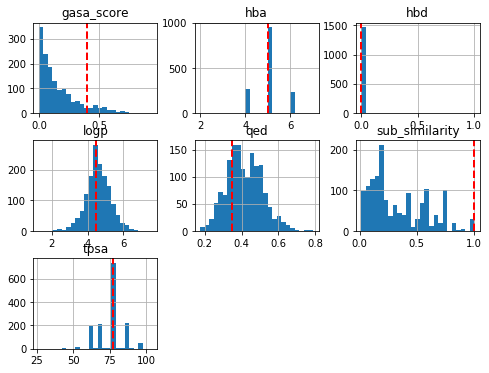

In [16]:
generator.plot()

In [17]:
display(generator.data.sort_values("sub_similarity").tail(10))

,logp,tpsa,sub_similarity,qed,hba,hbd,gasa_score
1247,4.4719,77.51,0.96139,0.349746,5,0,0.531514
25,4.7179,77.51,0.96139,0.333613,5,0,0.331254
852,4.3920,77.51,0.96139,0.283181,5,0,0.541529
1223,4.7821,77.51,1.00000,0.272466,5,0,0.336363
284,3.8578,77.51,1.00000,0.289063,5,0,0.055599
563,4.4719,77.51,1.00000,0.349746,5,0,0.157240
231,4.5715,77.51,1.00000,0.392156,5,0,0.156597
657,3.6917,77.51,1.00000,0.388863,5,0,0.468200
1295,3.5434,86.74,1.00000,0.310552,6,0,0.020861
872,4.8620,77.51,1.00000,0.329130,5,0,0.352443


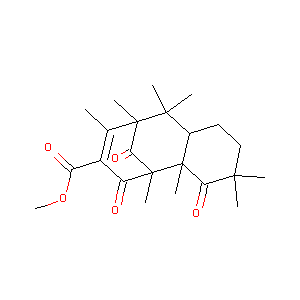

In [18]:
generator.showmol(657)
#display(Chem.Draw.MolToImage(generator.sani_mols[441]))